# Validate target data model

This notebook verifies that the target data model actually gives a faithful representation of the evolution of concentration of simulated halos.

In [1]:
import matplotlib.cm as cm
from time import time
from matplotlib import lines as mlines

In [2]:
import os
from astropy.table import Table
diffprof_drn = "/Users/aphearin/work/DATA/diffprof_data"
mdpl2 = Table.read(os.path.join(diffprof_drn, "MDPL2_halo_table.hdf5"))
bpl = Table.read(os.path.join(diffprof_drn, "BPL_halo_table.hdf5"))
print(bpl.keys())

['halo_id', 'conc_beta_early', 'conc_beta_late', 'conc_k', 'conc_lgtc', 'u_conc_beta_early', 'u_conc_beta_late', 'u_conc_k', 'u_conc_lgtc', 'logmp', 'mah_early', 'mah_late', 'mah_logtc', 'mah_k', 'log_mah_fit', 'conch_fit', 'tform_50', 'p_tform_50']


In [3]:
from diffprof.nfw_evolution import lgc_vs_lgt

lgc_vs_lgt_vmap = jjit(jvmap(lgc_vs_lgt, in_axes=(None, 0, 0, 0, 0)))

N_T = 25
TARR_FIT = np.linspace(2, 13.8, N_T)

lgconc_history_bpl = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), bpl["conc_lgtc"], bpl["conc_k"], bpl["conc_beta_early"], bpl["conc_beta_late"]))
lgconc_history_mdpl2 = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), mdpl2["conc_lgtc"], mdpl2["conc_k"], mdpl2["conc_beta_early"], mdpl2["conc_beta_late"]))


### Verify that we can use the latin hypercube sampler to evenly select halos by mass

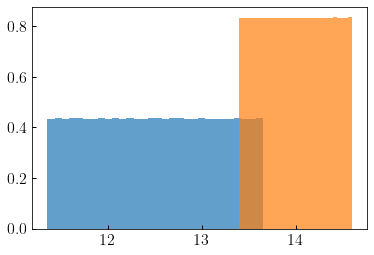

In [4]:
from diffprof.latin_hypercube import get_scipy_kdtree, retrieve_lh_sample_indices
tree_bpl = get_scipy_kdtree(bpl['logmp'])
tree_mdpl2 = get_scipy_kdtree(mdpl2['logmp'])

indx_bpl = retrieve_lh_sample_indices(tree_bpl, 11.35, 13.65, 1, 100_000)
indx_mdpl2 = retrieve_lh_sample_indices(tree_mdpl2, 13.4, 14.6, 1, 100_000)

fig, ax = plt.subplots(1, 1)
__=ax.hist(bpl['logmp'][indx_bpl], bins=30, density=True, alpha=0.7)
__=ax.hist(mdpl2['logmp'][indx_mdpl2], bins=30, density=True, alpha=0.7)


In [5]:
from diffprof.get_target_simdata import target_data_generator

N_MH_TARGETS, N_P_TARGETS = 20, 15

args = (bpl['logmp'][indx_bpl],
    mdpl2['logmp'][indx_mdpl2],
    lgconc_history_bpl[indx_bpl],
    lgconc_history_mdpl2[indx_mdpl2],
    bpl['p_tform_50'][indx_bpl],
    mdpl2['p_tform_50'][indx_mdpl2],
    N_MH_TARGETS,
    N_P_TARGETS
       )
gen = target_data_generator(*args)

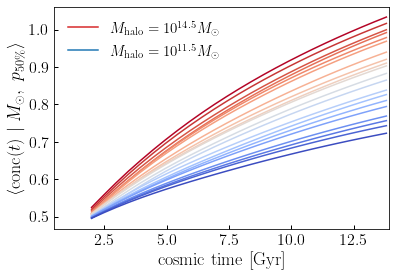

In [6]:
target_data = next(gen)
lgmhalo_targets, p50_targets = target_data[0:2]
lgc_mean_targets_lgm0, lgc_std_targets_lgm0 = target_data[2:4]
lgc_mean_targets_lgm0_p50, lgc_std_targets_lgm0_p50 = target_data[4:]

lgm_colors=cm.coolwarm(np.linspace(1,0,N_MH_TARGETS))
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0.5, 13.9)
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\langle{\rm conc}(t)\ \vert\ M_{\odot},\ p_{50\%}\rangle$')
for im in range(N_MH_TARGETS):
    __=ax.plot(TARR_FIT, lgc_mean_targets_lgm0[im, :], color=lgm_colors[im])

    
red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$M_{\rm halo}=10^{14.5}M_{\odot}$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$M_{\rm halo}=10^{11.5}M_{\odot}$')
leg=ax.legend(handles=[red_line, blue_line])


## Check $\langle\log_{10}c(t)\vert M_0\rangle$: simulation against target data model

In [7]:
from diffprof import target_data_model as tdm

In [8]:
im = -1
lgm = lgmhalo_targets[im]
pars = list(tdm.target_data_model_params_mean_lgconc.values())
plist = np.linspace(0, 1, 50)
mean_lgc_lgm = np.mean(np.array(
    [tdm.approximate_lgconc_vs_lgm_p50(TARR_FIT, lgm, p, *pars) for p in plist]), axis=0)
mean_lgc_lgm.shape

(25,)

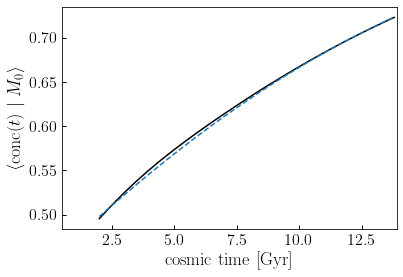

In [9]:
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0.5, 13.9)
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\langle{\rm conc}(t)\ \vert\ M_0\rangle$')
__=ax.plot(TARR_FIT, lgc_mean_targets_lgm0[im, :], color='k')
__=ax.plot(TARR_FIT, mean_lgc_lgm, '--', color=mblue)


## Check $\langle\log_{10}c(t)\vert M_0, p_{50\%}\rangle$: simulation against target data model

Working on lgm0 = 13.09


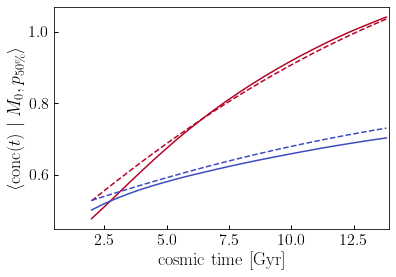

In [15]:
im = -10
lgm = lgmhalo_targets[im]
print("Working on lgm0 = {0:.2f}".format(lgm))

mean_lgc_lgm_p50 = np.array(
    [tdm.approximate_lgconc_vs_lgm_p50(TARR_FIT, lgm, p, *pars) for p in p50_targets])

p50_colors=cm.coolwarm(np.linspace(1, 0, N_P_TARGETS)) # red first
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0.5, 13.9)
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\langle{\rm conc}(t)\ \vert\ M_0, p_{50\%}\rangle$')

__=ax.plot(TARR_FIT, lgc_mean_targets_lgm0_p50[im, 0, :], color=p50_colors[0])
__=ax.plot(TARR_FIT, lgc_mean_targets_lgm0_p50[im, -1, :], color=p50_colors[-1])

__=ax.plot(TARR_FIT, mean_lgc_lgm_p50[0, :], '--', color=p50_colors[0])
__=ax.plot(TARR_FIT, mean_lgc_lgm_p50[-1, :], '--', color=p50_colors[-1])


In [13]:
lgmhalo_targets

array([11.57992935, 11.68940475, 11.87212269, 11.95333333, 12.23101077,
       12.30585171, 12.54344629, 12.66802711, 12.8270416 , 12.88776033,
       13.09217175, 13.25303632, 13.42912886, 13.51728579, 13.65784807,
       13.79045641, 14.01705579, 14.11379592, 14.2526213 , 14.42412293])

In [11]:
indx_p50_check = np.searchsorted(p50_targets, [0.1, 0.3, 0.5, 0.7, 0.9])
p50_check = p50_targets[indx_p50_check]

fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0.5, 13.9)
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\langle{\rm conc}(t)\ \vert\ M_0, p_{50\%}\rangle$')

for ip in indx_p50_check:
    __=ax.plot(TARR_FIT, lgc_mean_targets_lgm0_p50[im, ip, :], color=p50_colors[ip])
    __=ax.plot(TARR_FIT, mean_lgc_lgm_p50[ip, :], '--', color=p50_colors[ip])

IndexError: index 15 is out of bounds for axis 0 with size 15